# Анализ на Youtube в България <img src="https://upload.wikimedia.org/wikipedia/commons/e/ef/Youtube_logo.png" width="40" style="display:inline; vertical-align : middle"/> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Flag_of_Bulgaria.png/1200px-Flag_of_Bulgaria.png" width="40" style="display:inline; vertical-align : middle " />

Ще отговорим на въпросите:

*1. Кои са най-популярните категории видеоклипове в България?<br>
2. Кой е най-популярният видеоклип от всяка от категориите?<br>
3. Кога най-често се качват най-гледаните видеа (ден, час)?*

## *Import на нужни библиотеки и API key*

In [1]:
from dotenv import load_dotenv
import os
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
load_dotenv()
api_key = os.getenv("YOUTUBE_API_KEY")

## *Вземане на всички съществуващи категории за видеоклип*

In [2]:
url_categories = 'https://www.googleapis.com/youtube/v3/videoCategories'
params = {
    'part' : 'snippet',
    'regionCode' : 'BG',
    'hl' : 'bg',
    'key' : api_key
}
response = requests.get(url_categories, params = params)
categories = response.json()

## *Създаване на 'mapper' за ID и име на категория, който ще използваме по-късно*

In [3]:
category_mapping = {
    item['id']: item['snippet']['title']
    for item in categories['items']
}

print(category_mapping)

{'1': 'Филми и анимация', '2': 'Коли и превозни средства', '10': 'Музика', '15': 'Домашни любимци и животни', '17': 'Спорт', '18': 'Късометражни филми', '19': 'Пътувания и събития', '20': 'Игри', '21': 'Видеоблог', '22': 'Хора и блогове', '23': 'Комедия', '24': 'Развлечения', '25': 'Новини и политика', '26': 'Ръководства и стил', '27': 'Образование', '28': 'Наука и технологии', '30': 'Филми', '31': 'Аниме/Анимация', '32': 'Екшън/Приключения', '33': 'Класика', '34': 'Комедия', '35': 'Документални', '36': 'Драма', '37': 'Семейни', '38': 'Чуждестранни', '39': 'Ужаси', '40': 'Научна фантастика/фентъзи', '41': 'Трилър', '42': 'Късометражни филми', '43': 'Предавания', '44': 'Трейлъри'}


## *Вземане на най-популярните видеоклипове в България в момента на заявката\**

###### *\*API на Youtube има лимит на резултатите (50), които можем да получим с една заявка. Също така, максималния брой видеоклипове, подредени по популярност, които можем да вземем, са 200.*

In [4]:
full_data = []
page_token = None
url_videos = 'https://www.googleapis.com/youtube/v3/videos'
for _ in range(4):
    params = {
        'part' : 'snippet, statistics',
        'chart' : 'mostPopular',
        'regionCode' : 'BG',
        'maxResults' : '50',
        'key' : api_key
    }

    if page_token:
        params['pageToken'] = page_token
    
    response = requests.get(url_videos, params=params).json()
    full_data.extend(response['items'])
    page_token = response.get('nextPageToken')
    
    if not page_token:
        break

## *Вземане на нужните параметри и подреждане в DataFrame*

In [5]:
video_data = []
for item in full_data:
    video_data.append({
        'title' : item['snippet']['title'],
        'category' : item['snippet']['categoryId'],
        'channel' : item['snippet']['channelTitle'],
        'view_count' : item['statistics']['viewCount']    
    })
df = pd.DataFrame(video_data)
df.head()

,title,category,channel,view_count
0,"PRESLAVA х AZIS - KOY BE, KOY / Преслава x Аз...",10,PRESLAVA,3335274
1,Five Nights at Freddy's 2 | Official Trailer,24,Universal Pictures,8946405
2,МАЙНКРАФТ СТРОЕНЕ 10 СЕК VS 1 МИН VS 10 МИН | ...,20,NEgamer,87274
3,KONSTANTIN & MARIANA - NYAMA DA SE DAM / КОНСТ...,10,Konstantin,3117811
4,Predator: Badlands | Official Trailer,1,20th Century Studios,15646040


## *Използването на mapper-а, който създадохме по-рано за преобразуването на колоната 'Категории' от ID към име*

In [6]:
df['category'] = df['category'].map(category_mapping)
df.head()

,title,category,channel,view_count
0,"PRESLAVA х AZIS - KOY BE, KOY / Преслава x Аз...",Музика,PRESLAVA,3335274
1,Five Nights at Freddy's 2 | Official Trailer,Развлечения,Universal Pictures,8946405
2,МАЙНКРАФТ СТРОЕНЕ 10 СЕК VS 1 МИН VS 10 МИН | ...,Игри,NEgamer,87274
3,KONSTANTIN & MARIANA - NYAMA DA SE DAM / КОНСТ...,Музика,Konstantin,3117811
4,Predator: Badlands | Official Trailer,Филми и анимация,20th Century Studios,15646040


## *Групиране на данните по категории и брой видеоклипове от всяка категория*

In [7]:
category_counts = df.groupby('category').size().sort_values(ascending = False).reset_index(name = 'count')
category_counts

,category,count
0,Музика,91
1,Игри,81
2,Развлечения,9
3,Хора и блогове,7
4,Наука и технологии,3
5,Филми и анимация,3
6,Коли и превозни средства,1
7,Комедия,1
8,Новини и политика,1
9,Пътувания и събития,1


## *Построяване на диаграма и нагледно отговаряне на въпроса: <br><br>'Кои са най-популярните категории видеоклипове в България?'*

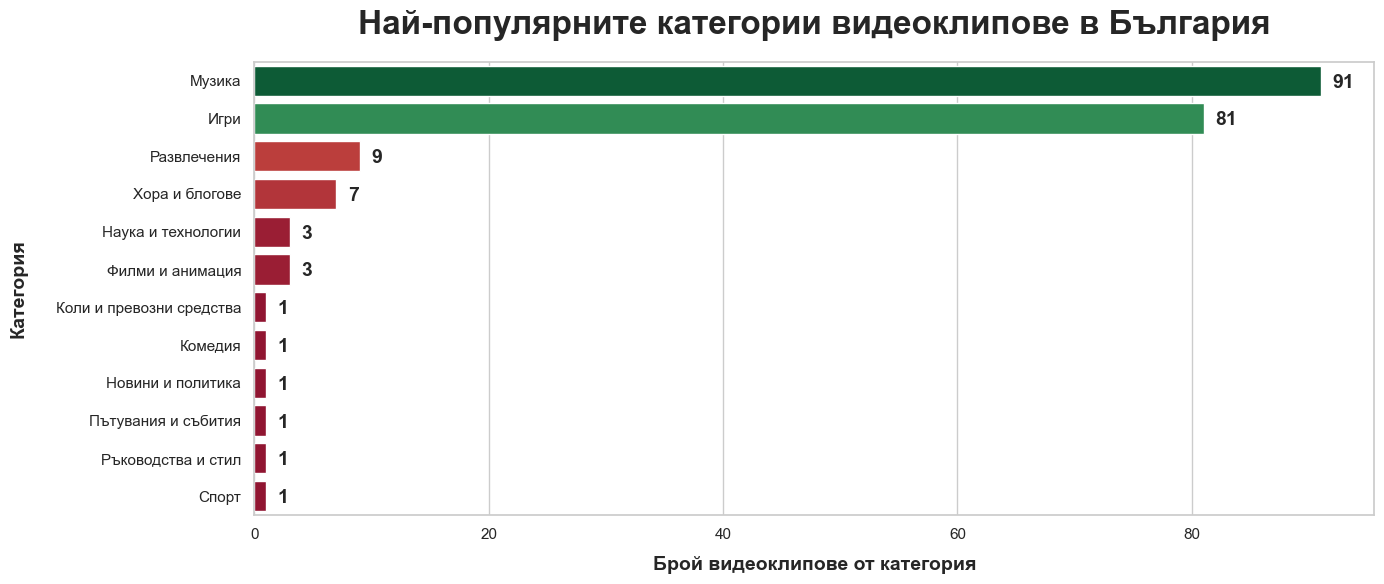

In [8]:
sns.set(style = 'whitegrid')

plt.figure(figsize = (14,6))
barplot = sns.barplot(data = category_counts, x = 'count', y = 'category', hue = 'count', palette = 'RdYlGn', orient = 'h', legend = False)

for i, row in category_counts.iterrows():
    plt.text(row['count'] + 1, i, row['count'], ha = 'left', va = 'center_baseline', fontsize=14, fontweight='bold')

plt.title('Най-популярните категории видеоклипове в България', fontsize = 24, fontweight = 'bold', pad = 20, loc = 'center')
plt.xlabel('Брой видеоклипове от категория', fontsize = 14, fontweight = 'bold', labelpad = 10)
plt.ylabel('Категория', fontsize = 14, fontweight = 'bold', labelpad = 20)
plt.tight_layout()
plt.show()

## *Кой е най-популярният видеоклип от всяка от категориите?*

In [9]:
pd.set_option('display.max_colwidth', None)
most_popular_videos = df.drop_duplicates(subset = 'category', ignore_index = True)[['category', 'title', 'channel']]
most_popular_videos

,category,title,channel
0,Музика,"PRESLAVA х AZIS - KOY BE, KOY / Преслава x Азис - Кой бе, кой ( Official video ) | 2025",PRESLAVA
1,Развлечения,Five Nights at Freddy's 2 | Official Trailer,Universal Pictures
2,Игри,МАЙНКРАФТ СТРОЕНЕ 10 СЕК VS 1 МИН VS 10 МИН | ЕПИЗОД 2,NEgamer
3,Филми и анимация,Predator: Badlands | Official Trailer,20th Century Studios
4,Хора и блогове,"ФОРТНАЙТ, НО НА ВСЯКО УМИРАНЕ ЯМ НАЙ-ЛЮТАТА ХРАНА!",Alpha Alex
5,Спорт,Sprint Highlights | 2025 Belgian Grand Prix,FORMULA 1
6,Наука и технологии,Играя СТАНИ БОГАТ с Chat-GPT,Aethelthryth Clips
7,Ръководства и стил,رسميا كريستيانو وحقيقة بكج الايبك المجاني 🔥🤯 جميع احداث يوم الخميس المميز 😱|efootball 2025,من بره التمنتاشر
8,Пътувания и събития,THE RUSSIAN PREMIER EXPERIENCE,Anomaly
9,Новини и политика,Doomsday☄️Air Defense Suppressed💥Battle for Kondrativka⚔️ DRG Already in Pokrovsk🕵️‍♂️ MS 2025.07.21,Military Summary


## *Подготвяне на данните, за да отговорим на третия въпрос: <br><br>Кога най-често се качват най-гледаните видеа (ден, час)?*

In [10]:
video_data = []
for item in full_data:
    video_data.append({
        'title' : item['snippet']['title'],
        'channel' : item['snippet']['channelTitle'],
        'published' : item['snippet']['publishedAt']    
    })
df = pd.DataFrame(video_data)
df.head()

,title,channel,published
0,"PRESLAVA х AZIS - KOY BE, KOY / Преслава x Азис - Кой бе, кой ( Official video ) | 2025",PRESLAVA,2025-07-14T15:01:05Z
1,Five Nights at Freddy's 2 | Official Trailer,Universal Pictures,2025-07-24T11:19:16Z
2,МАЙНКРАФТ СТРОЕНЕ 10 СЕК VS 1 МИН VS 10 МИН | ЕПИЗОД 2,NEgamer,2025-07-25T16:01:55Z
3,KONSTANTIN & MARIANA - NYAMA DA SE DAM / КОНСТАНТИН И МАРИАНА - НЯМА ДА СЕ ДАМ,Konstantin,2025-07-16T17:45:05Z
4,Predator: Badlands | Official Trailer,20th Century Studios,2025-07-21T16:00:06Z


## *Добавяне на колони за ден от седмицата (+ съответния му номер) и час на публикуване*

In [11]:
df['published'] = pd.to_datetime(df['published'])
df['published_day'] = df['published'].dt.day_name()
df['day_id'] = df['published'].dt.weekday + 1
df['published_hour'] = df['published'].dt.hour
df.head()

,title,channel,published,published_day,day_id,published_hour
0,"PRESLAVA х AZIS - KOY BE, KOY / Преслава x Азис - Кой бе, кой ( Official video ) | 2025",PRESLAVA,2025-07-14 15:01:05+00:00,Monday,1,15
1,Five Nights at Freddy's 2 | Official Trailer,Universal Pictures,2025-07-24 11:19:16+00:00,Thursday,4,11
2,МАЙНКРАФТ СТРОЕНЕ 10 СЕК VS 1 МИН VS 10 МИН | ЕПИЗОД 2,NEgamer,2025-07-25 16:01:55+00:00,Friday,5,16
3,KONSTANTIN & MARIANA - NYAMA DA SE DAM / КОНСТАНТИН И МАРИАНА - НЯМА ДА СЕ ДАМ,Konstantin,2025-07-16 17:45:05+00:00,Wednesday,3,17
4,Predator: Badlands | Official Trailer,20th Century Studios,2025-07-21 16:00:06+00:00,Monday,1,16


## *Групиране на данните по деня (+ съответния му номер) и добавяне на колона за брой качени видеоклипове от всеки ден*

In [12]:
day_counts = df.groupby(['published_day', 'day_id']).size().reset_index(name = 'count')
day_counts

,published_day,day_id,count
0,Friday,5,33
1,Monday,1,17
2,Saturday,6,22
3,Sunday,7,22
4,Thursday,4,58
5,Tuesday,2,24
6,Wednesday,3,24


## *Промяна на индекса на DataFrame в day_id и премахването на day_id от колоните*

In [13]:
day_counts.index = day_counts['day_id']
day_counts = day_counts.drop(axis = 1, columns = 'day_id')
day_counts

,published_day,count
day_id,,
5,Friday,33
1,Monday,17
6,Saturday,22
7,Sunday,22
4,Thursday,58
2,Tuesday,24
3,Wednesday,24


## *Подреждане на данните според последователността на дните от седмицата*

In [14]:
day_counts = day_counts.sort_index()
day_counts

,published_day,count
day_id,,
1,Monday,17
2,Tuesday,24
3,Wednesday,24
4,Thursday,58
5,Friday,33
6,Saturday,22
7,Sunday,22


## *Създаване и прилагане на mapper за по-лесна четимост на български на дните*

In [15]:
day_mapper = {
    'Monday' : 'Понеделник',
    'Tuesday' : 'Вторник',
    'Wednesday' : 'Сряда',
    'Thursday' : 'Четвъртък',
    'Friday' : 'Петък',
    'Saturday' : 'Събота',
    'Sunday' : 'Неделя',
}

day_counts['published_day'] = day_counts['published_day'].map(day_mapper)
day_counts

,published_day,count
day_id,,
1,Понеделник,17
2,Вторник,24
3,Сряда,24
4,Четвъртък,58
5,Петък,33
6,Събота,22
7,Неделя,22


## *Построяване на графика за въпроса: <br><br> Кога най-често се качват най-гледаните видеа (ден)?*

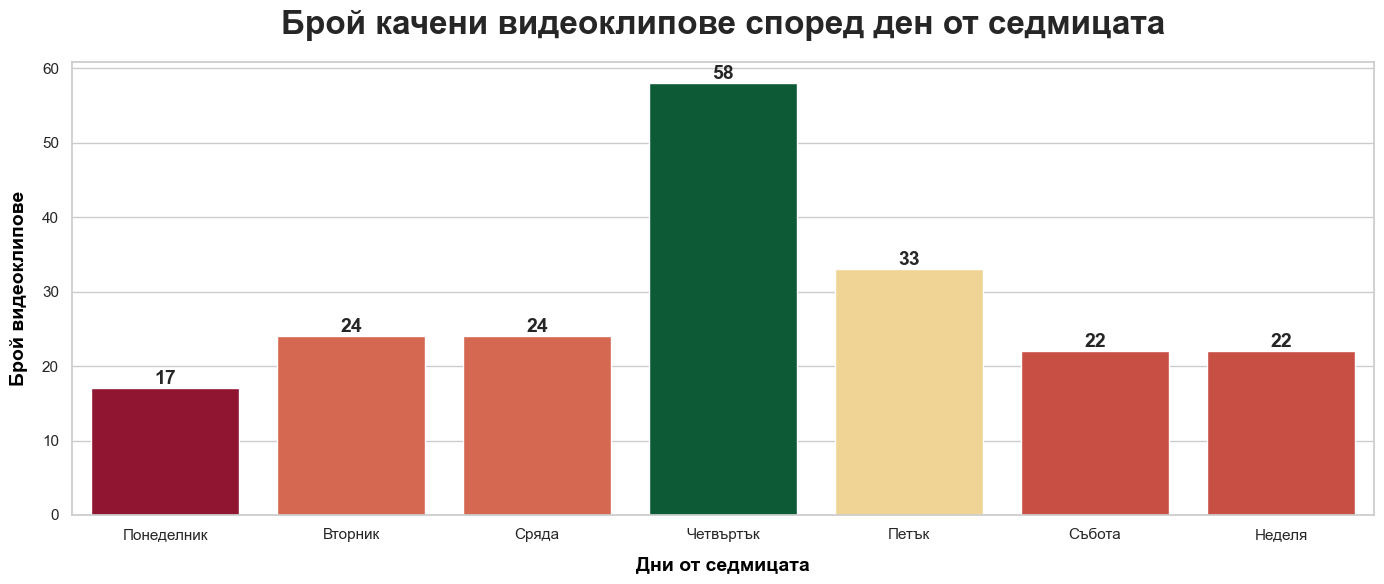

In [16]:
plt.figure(figsize = (14,6))
sns.barplot(data = day_counts, x = 'published_day', y = 'count', hue = 'count', palette = 'RdYlGn', legend = False)


for _, row in day_counts.iterrows():
    plt.text(row['published_day'], row['count'], row['count'], ha = 'center', va = 'bottom', fontsize = 14, fontweight = 'bold')

plt.title('Брой качени видеоклипове според ден от седмицата', fontsize = 24, fontweight = 'bold', pad = 20, loc = 'center')
plt.xlabel('Дни от седмицата', fontsize = 14, fontweight = 'bold', labelpad = 10, color = 'black')
plt.ylabel('Брой видеоклипове', fontsize = 14, fontweight = 'bold', labelpad = 10, color = 'black')
plt.tight_layout()
plt.show()

## *Построяване на графика за въпроса: <br><br> Кога най-често се качват най-гледаните видеа (час)?*

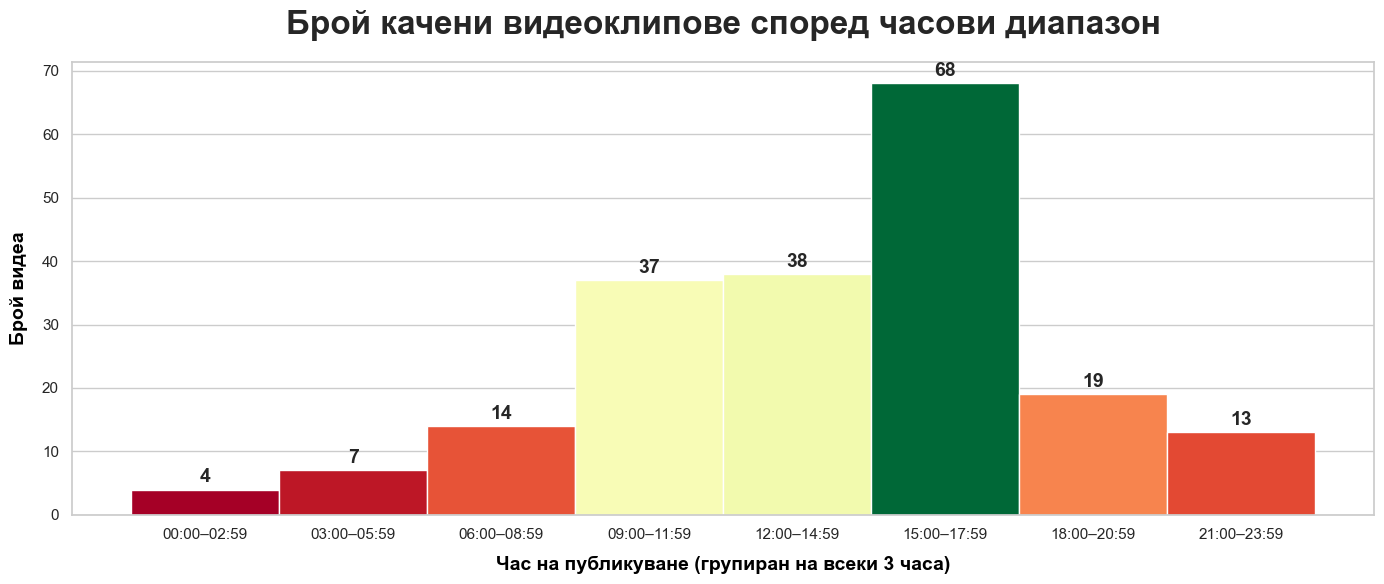

In [17]:
plt.figure(figsize = (14,6))
bars = df['published_hour'].hist(bins = range(0,25,3))

cmap = plt.cm.RdYlGn
heights = [bar.get_height() for bar in bars.patches]
norm = plt.Normalize(min(heights), max(heights))
for bar, height in zip(bars.patches, heights):
    bar.set_facecolor(cmap(norm(height)))

for bar in bars.patches:
    height = bar.get_height()
    bars.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{int(height)}',
            ha='center', va='bottom', 
            fontsize=14, fontweight='bold')

bin_edges = list(range(0, 22, 3))
midpoints = [x + 1.5 for x in bin_edges]
xtick_labels = [f"{start:02d}:00–{start+2:02d}:59" for start in range(0, 22, 3)]

plt.xticks(ticks=midpoints, labels=xtick_labels)
plt.title('Брой качени видеоклипове според часови диапазон', fontsize = 24, fontweight = 'bold', pad = 20, loc = 'center')
plt.xlabel('Час на публикуване (групиран на всеки 3 часа)', fontsize = 14, fontweight = 'bold', labelpad = 10, color = 'black')
plt.ylabel('Брой видеа', fontsize = 14, fontweight = 'bold', labelpad = 10, color = 'black')
plt.grid(axis = 'x')
plt.tight_layout()
plt.show()